## Content-Based Anime Recommender

Hello! In this project I analyze anime data based on a couple metrics such as rating, genre and type. I then visualize anime based on differences in genre, and measure varying rating means across total episode counts. Lastly, I end with a content-based recommender that takes into account an anime's genres, episode counts, rating, and the number of members that left a review. The model works to compare these features through cosine similarity. This is my first recommender and I look forward to improving upon this in the future by acquiring data that would allow for a collaborative filtering method as well.


#### Note:
This is a bit of an older project that I am just now getting to post, so my methodologies for some of the techniques used in this have changed since. There are many things I would do differently/further expand on but I like to keep the project this way as a reminder and to "track my growth", so to speak.

Still, I'm happy with this work and I learned a lot. I went into this project with a lot of curiosity and I can see that I was really following wherever the data took me during exploration and visualization. This helped me to not have a limited mindset when asking and refining questions. That's a theme I hope to hold onto as I continue to learn.

#### Credits

I want to thank Kaggle user CooperUnion for providing the data on anime.
https://www.kaggle.com/CooperUnion/anime-recommendations-database


##### David Lopez
University of California, San Diego
<br> david.eric.lopez@gmail.com

In [1]:
#Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind, f_oneway

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#Reading the anime dataset into the notebook
anime = pd.read_csv('anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
#Cleaning. DF will only include TV anime. Meaning OVA's(original animation & videos) and Movies are dropped
#OVA's did not go through a television run and had alternative distributions.
#Movies were dropped because they could also vary in distribution.

anime = anime.dropna()
anime = anime.loc[anime['type'] == 'TV']
anime = anime.loc[anime['episodes'] != 'Unknown']

In [4]:
#Changing dtype of these columns (formerly strings)
anime['episodes'] = anime['episodes'].astype(int)
anime['rating'] = anime['rating'].astype(float)

# The Genre Column

Currently the genre column is a bit weird to work with and makes genre-specific analyses difficult to perform. Since the variables are stored as strings rather than a list, an anime labeled as (Action, Adventure) would be categorized differently from one labeled (Adventure, Action). To avoid this, I will iterate through every index in the genre column to identify which anime have which genre in a more tidy format.

In [5]:
# Creating objects that will denote whether or not is classified
# under a particular genre or not, in order to split up the currently
# genre column which is difficult to work with

action = anime['genre'].str.contains(pat ='Action')
adventure = anime['genre'].str.contains(pat ='Adventure')
cars = anime['genre'].str.contains(pat ='Cars')
comedy = anime['genre'].str.contains(pat ='Comedy')
dementia = anime['genre'].str.contains(pat ='Dementia')
demons = anime['genre'].str.contains(pat ='Demons')
drama = anime['genre'].str.contains(pat ='Drama')
ecchi = anime['genre'].str.contains(pat ='Ecchi')
fantasy = anime['genre'].str.contains(pat ='Fantasy')
game = anime['genre'].str.contains(pat ='Game')
harem = anime['genre'].str.contains(pat ='Harem')
historical = anime['genre'].str.contains(pat ='Historical')
horror = anime['genre'].str.contains(pat ='Horror')
josei = anime['genre'].str.contains(pat ='Josei')
kids = anime['genre'].str.contains(pat ='Kids')
magic = anime['genre'].str.contains(pat ='Magic')
martial_arts = anime['genre'].str.contains(pat ='Martial Arts')
mecha = anime['genre'].str.contains(pat ='Mecha')
military = anime['genre'].str.contains(pat ='Military')
music = anime['genre'].str.contains(pat ='Music')
mystery = anime['genre'].str.contains(pat ='Mystery')
parody = anime['genre'].str.contains(pat ='Parody')
police = anime['genre'].str.contains(pat ='Police')
psychological = anime['genre'].str.contains(pat ='Psychological')
romance = anime['genre'].str.contains(pat ='Romance')
samurai = anime['genre'].str.contains(pat ='Samurai')
school = anime['genre'].str.contains(pat ='School')
sci_fi = anime['genre'].str.contains(pat ='Sci-Fi')
seinen = anime['genre'].str.contains(pat ='Seinen')
shoujo = anime['genre'].str.contains(pat ='Shoujo')
shounen = anime['genre'].str.contains(pat ='Shounen')
slice_of_life = anime['genre'].str.contains(pat ='Slice of Life')
space = anime['genre'].str.contains(pat ='Space')
sports = anime['genre'].str.contains(pat ='Sport')
super_power = anime['genre'].str.contains(pat ='Super Power')
thriller = anime['genre'].str.contains(pat ='Thriller')
vampire = anime['genre'].str.contains(pat ='Vampire')

In [6]:
#Adding the classifiers to the data frame
df = anime[['anime_id', 'name', 'episodes', 'rating', 'members']]
df = df.assign(action = action, adventure = adventure, cars = cars, comedy = comedy, dementia = dementia,
               demons = demons, drama = drama, ecchi = ecchi, fantasy = fantasy, game = game, harem = harem,
               historical = historical, horror = horror, josei = josei, kids = kids, magic = magic,
               martial_arts = martial_arts, mecha = mecha, military = military, music = music, mystery = mystery,
               parody = parody, police = police, psychological = psychological, romance = romance,
               samurai = samurai, school = school, sci_fi = sci_fi, seinen = seinen, shoujo = shoujo, shounen = shounen,
               slice_of_life = slice_of_life, space = space, sports = sports, super_power = super_power,
               thriller = thriller, vampire = vampire) 

In [7]:
#Creating the tidy data frame
df = df.melt(id_vars = ['anime_id', 'name','episodes', 'rating','members'], value_vars = ['action', 'adventure', 'cars', 'comedy',
                                                                              'dementia', 'demons', 'drama', 'ecchi',
                                                                              'fantasy', 'game', 'harem', 'historical',
                                                                              'horror', 'josei', 'kids', 'magic',
                                                                              'martial_arts', 'mecha', 'military', 'music',
                                                                              'mystery', 'parody', 'police', 'psychological',
                                                                              'romance', 'samurai', 'school', 'sci_fi',
                                                                              'seinen', 'shoujo', 'shounen', 'slice_of_life',
                                                                              'space', 'sports', 'super_power', 'thriller',
                                                                              'vampire'])

In [8]:
# Currently the data frame includes indeces that simply state an anime does not contain a particular genre 
# (i.e. Action = False)
# Since I'm only interested in which genres an anime DOES contain, I choose to drop the unwanted rows
# This will also help speed up processing later on

df = df.rename(columns = {'variable':'genre'})
df = df.loc[df['value'] != False]
df = df.drop(columns = 'value')
df = df.set_index('anime_id')

In [9]:
df.head()

,name,episodes,rating,members,genre
anime_id,,,,,
5114,Fullmetal Alchemist: Brotherhood,64,9.26,793665,action
28977,Gintama°,51,9.25,114262,action
9969,Gintama&#039;,51,9.16,151266,action
11061,Hunter x Hunter (2011),148,9.13,425855,action
15417,Gintama&#039;: Enchousen,13,9.11,81109,action


The main dataframe is now complete and ready for further exploration. Since anime is generally divided into seasons, I chose to do seperate analyses on seasonal anime, long anime, and legacy anime. Seasonal anime lasts only one season, hence the name. Occasionally, these shows will get renewed for additional seasons, those shows will be contained within the long anime dataframe. Shows that last particularly long will be categorized as legacy anime.

##### Seasonal Anime
A typical seasonal anime can run anywhere from just a few episodes to a max of 26. Thus, a cap will be placed at the 26 episode mark.

In [10]:
#Creating the seasonal anime df. Seasonal anime is max 26 episodes
#Setting the episodes and rating column as integers and floats so they can be plotted properly (instead of remaining str)

seas_df = df[df['episodes'] <= 26]

##### Long Anime
I place a cutoff of 86 episodes as this helps better capture anime based on how many years they have spent on the air. As some anime will produce strictly 24 episode seasons, while other will alternate between 24 and 13 episode seasons, or some combination of both. An 86 episode cutoff is essentially placing a hard cap that can account for this variability through assuming an anime has had a max of 5 years on the air.

In [11]:
# Creating the long anime df. Long anime has been renewed for several seasons.

long_df = df.loc[df['episodes'] > 26]
long_df = long_df.loc[long_df['episodes'] <= 86]

##### Legacy Anime
Legacy anime is the longest of all. These series have been on the air for over 5 years and are often times still producing new episodes. Think series such as Dragonball Z, One Piece, and Naruto.

In [12]:
# Creating the legacy anime df.

legacy_df = df.loc[df['episodes'] > 72]

# Task: Exploration and Visualization

I am curious to see if perhaps the length that a show has been running could affect its overall ratings. My theory is is that the longer anime has been on TV, the less variability we can expect from its ratings. For example, does anime generally get better with age? Are "short and sweet" shows preferred over long and drawn out ones?

### Seasonal Anime

In [13]:
print('Description of Seasonal Anime')
seas_df.describe()

Description of Seasonal Anime


,episodes,rating,members
count,8695.000000,8695.000000,8695.000000
mean,17.102128,7.084772,68027.587809
std,6.473205,0.786645,104014.005326
min,2.000000,3.000000,20.000000
25%,12.000000,6.635000,4790.000000
50%,13.000000,7.140000,27080.000000
75%,25.000000,7.580000,87240.000000
max,26.000000,9.170000,896229.000000


Text(0.5, 1.0, 'Rating Distribution (Seasonal Anime)')

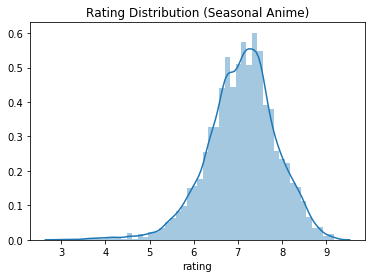

In [14]:
sns.distplot(seas_df['rating']).set_title('Rating Distribution (Seasonal Anime)')

Text(0.5, 1.0, 'Episode Count Distribution (Seasonal Anime)')

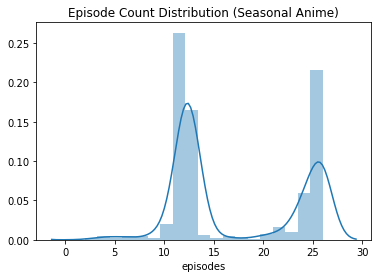

In [15]:
sns.distplot(seas_df['episodes']).set_title('Episode Count Distribution (Seasonal Anime)')

This bimodal distribution is to be expected as most anime in this dataframe will be either a half season (13 episodes) or a full season (26 episodes) long. In fact, sometimes an anime will have two 13 episode seasons. This is most common in particularly popular anime that is adapted from a manga comic. Thus, the hype surrounding these shows is a marketing tactic to prolong the excitement within the community.

Text(0.5, 1.0, 'Ratings Over Episode Count (Seasonal Anime)')

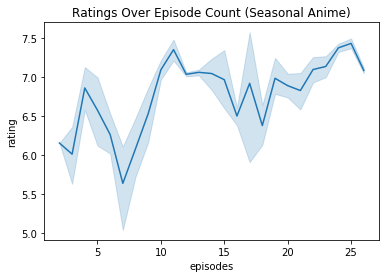

In [16]:
sns.lineplot(x = 'episodes', y = 'rating', data = seas_df).set_title('Ratings Over Episode Count (Seasonal Anime)')

### Long Anime

In [17]:
print('Description of Long Anime')
long_df.describe()

Description of Long Anime


,episodes,rating,members
count,3141.000000,3141.000000,3.141000e+03
mean,48.312639,7.005969,2.092403e+04
std,10.526838,0.708971,7.596178e+04
min,27.000000,3.000000,1.200000e+01
25%,40.000000,6.570000,4.310000e+02
50%,50.000000,7.020000,1.763000e+03
75%,52.000000,7.440000,9.331000e+03
max,86.000000,9.260000,1.013917e+06


Text(0.5, 1.0, 'Rating Disrtibution (Long Anime)')

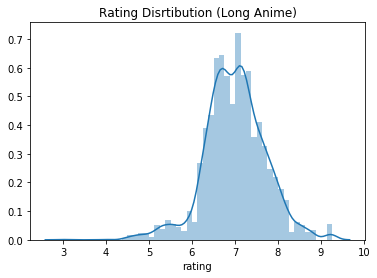

In [18]:
sns.distplot(long_df['rating']).set_title('Rating Disrtibution (Long Anime)')

Text(0.5, 1.0, 'Episode Count Distribution (Long Anime)')

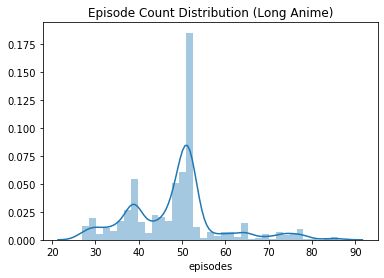

In [19]:
sns.distplot(long_df['episodes']).set_title('Episode Count Distribution (Long Anime)')

Text(0.5, 1.0, 'Ratings Over Episode Count (Long Anime)')

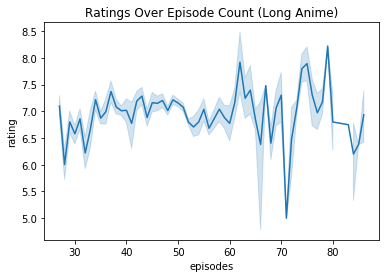

In [20]:
sns.lineplot(x = 'episodes', y = 'rating', data = long_df).set_title('Ratings Over Episode Count (Long Anime)')

### Legacy Anime

In [21]:
print('Description of Legacy Anime')
legacy_df.describe()

Description of Legacy Anime


,episodes,rating,members
count,755.000000,755.000000,755.000000
mean,177.123179,7.196212,53697.870199
std,232.038926,0.799342,118604.587628
min,73.000000,4.600000,35.000000
25%,94.000000,6.660000,250.000000
50%,112.000000,7.200000,3623.000000
75%,170.000000,7.810000,36623.000000
max,1818.000000,9.130000,683297.000000


Text(0.5, 1.0, 'Rating Distributions (Legacy Anime)')

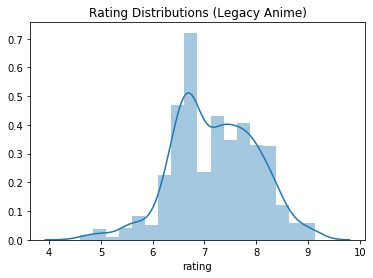

In [22]:
sns.distplot(legacy_df['rating']).set_title('Rating Distributions (Legacy Anime)')

I will not be creating a line plot of this data frame because it's episodes count shows a max of 1818 episodes. This plot would not be useful for interpretation. But the distribution plot is mouch more skewed right than the previous plots. Additionally it has a very prominent peak at around 6.8, and much more subtle peal at roughly 7.5.

Text(0.5, 1.0, 'Episode Count Distribution (Legacy Anime)')

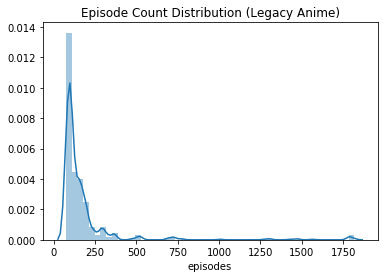

In [23]:
#Jointplot showing distribution and frequency of datapoints
sns.distplot(legacy_df['episodes']).set_title('Episode Count Distribution (Legacy Anime)')

There's a very obvious peak but to get a better understanding of what's going on there we will need to limit the x-axis. But I am curious to see what that small bump at the very end of the plot is! I will use .loc to ensure I'm grabbing all of the shows near that upper bound.

In [24]:
#legacy_df['episodes'].idxmax()
legacy_df.loc[legacy_df['episodes'] > 1500]

,name,episodes,rating,members,genre
anime_id,,,,,
2471,Doraemon (1979),1787,7.76,14233,adventure
2471,Doraemon (1979),1787,7.76,14233,comedy
12393,Oyako Club,1818,6.18,160,comedy
2471,Doraemon (1979),1787,7.76,14233,fantasy
2471,Doraemon (1979),1787,7.76,14233,kids
23349,Kirin Monoshiri Yakata,1565,5.56,116,kids
2471,Doraemon (1979),1787,7.76,14233,sci_fi
2471,Doraemon (1979),1787,7.76,14233,shounen
12393,Oyako Club,1818,6.18,160,slice_of_life


"Oyako Club" is an anime that has been on the air for nearly 20 years! But how did it get so many episodes you ask? This anime's episodes actually only last about 5 minutes each, therefore it's pretty quick to pump out new content.

On the other hand, "Doraemon (1979)" had been on the air for 26 years while producing full length 25 minute episodes! This show is actually a sequel to the original (named simply "Doraemon"), which is only 26 episodes long.

"Kirin Monoshiri Yakata" was a sort of "lost series" and not too much is known about it. It was on the air for about 9 years and produced 1565 5 minute episodes throughout that time. It's goal was to teach kids history lessons, which probably explains why it was so poorly rated!

As these are all pretty extreme cases, given that two are kids kids anime and two are only 5 minute episodes, I think our data is best if not skewed by these shows. Thus I will be dropping them from our set.

(86, 500)

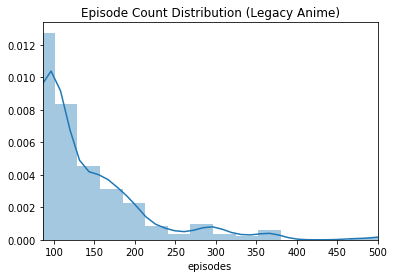

In [25]:
# Dropping this extreme cases from both the legacy and main dataframe

df = df.loc[df['episodes'] < 1500]
legacy_df = legacy_df.loc[legacy_df['episodes'] < 1500]

#Redone Distribution plot, now with a limited x-axis

sns.distplot(legacy_df['episodes']).set_title('Episode Count Distribution (Legacy Anime)')
plt.xlim(86, 500)

#### All Anime

Now that we have a good idea of how these different divisions of anime can vary, I would now like to see how these results compare to the overall data frame. Additionally, some unique tests will be performed on this as well. For the same reason as for the legacy plot, I will also be limiting which visualizations I will perform here as well.

In [26]:
print('Description of All Anime:')
df.describe()

Description of All Anime:


,episodes,rating,members
count,12432.000000,12432.000000,1.243200e+04
mean,32.717664,7.069419,5.572167e+04
std,51.097753,0.769577,1.011904e+05
min,2.000000,3.000000,1.200000e+01
25%,12.000000,6.610000,1.328500e+03
50%,24.000000,7.100000,1.344400e+04
75%,39.000000,7.560000,6.563300e+04
max,1471.000000,9.260000,1.013917e+06


Text(0.5, 1.0, 'Rating Distributions for All Anime')

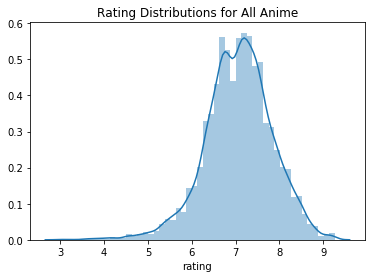

In [27]:
sns.distplot(df['rating']).set_title('Rating Distributions for All Anime')

(0, 10)

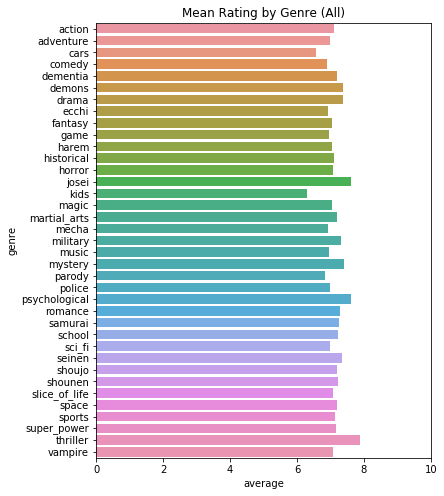

In [28]:
#Checking the mean rating, grouped by genre, for all anime

#creating a dataframe that takes into account proportions, rather than raw counts
prop_df = (df['rating']
           .groupby(df['genre'])
           .mean()
           .rename('average', inplace = True)
           .reset_index())

#adjusting the figure size
plt.figure(figsize = (6,8))    

#initializing the barplot
sns.barplot(x = 'average', y = 'genre', data = prop_df).set_title('Mean Rating by Genre (All)')

plt.xlim(0, 10)

Text(0.5, 1.0, 'Mean Episode Count by Genre (All)')

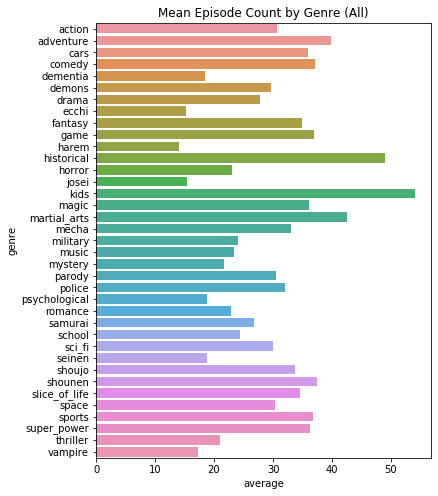

In [29]:
#creating a similar dataframe, but this time using the proportion of episode counts
prop_df2 = (df['episodes']
           .groupby(df['genre'])
           .mean()
           .rename('average', inplace = True)
           .reset_index())

#adjusting figure size
plt.figure(figsize = (6,8))    

#initialiing the barplot
sns.barplot(x = 'average', y = 'genre', data = prop_df2).set_title('Mean Episode Count by Genre (All)')


This is very interesting. Even having dropped the two extremities, not only are kids anime the lowest rated, but they exceed all other genres in average episode count as well! But is this the case for other genres as well? To do this I must check if there is any observable relationship through statistics and visualization.

In [30]:
#creating the kids data frame

#selecting desired metrics
kid_data = df[['genre', 'episodes', 'rating']]

#only including kids anime
kid_data = kid_data.loc[kid_data['genre'] == 'kids']
kid_data.head()

,genre,episodes,rating
anime_id,,,
6586,kids,50,8.07
2150,kids,78,7.95
31592,kids,47,7.91
6024,kids,104,7.90
2828,kids,51,7.90


In [31]:
#pearson r correlation to observe if there is a correlation between rating and episode count in kids anime
stat, p = pearsonr(kid_data['rating'], kid_data['episodes'])

#printing the findings
print('stat=%.3f, p=%.3f' % (stat, p))

#a p-value above 0.05 will be considered an insignificant finding
if p > 0.05:
    print('Probably insignificant')
#a p-value below 0.05 is a significant finding
else:
    print('Probably significant')

stat=0.110, p=0.022
Probably significant


(0, 500)

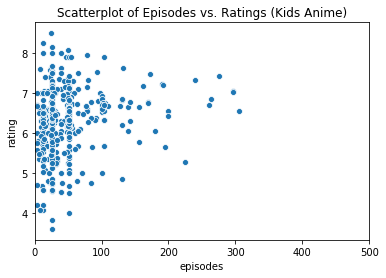

In [32]:
#plotting the rating trends for kids anime and episode count
sns.scatterplot(x = 'episodes', y = 'rating', data = kid_data).set_title('Scatterplot of Episodes vs. Ratings (Kids Anime)')
plt.xlim(0,500)

This was a fun aside, but as the correlation test showed, there could potentially be a relationship. Though this relationship definitely doesnt represent the majority. With a stricter p-value bound, we would have immediately dismissed the claim. Additionally, when we look at the larger data set, we see that a relationship doesn't really exist at all.

(0, 100)

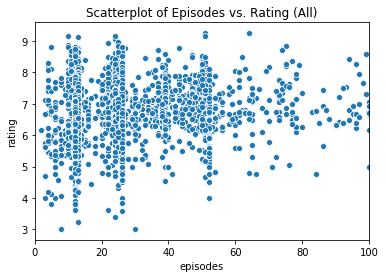

In [33]:
#Plotting the rating and episode count trends for all anime
sns.scatterplot(x = 'episodes', y = 'rating', data = df).set_title('Scatterplot of Episodes vs. Rating (All)')
plt.xlim(0,100)

Interstingly enough, this plot does highlight the tendency for anime to follow a seasonal pattern, as we see well-defined lines at the 13, 26, 39, and 52 episodes mark. Most anime falls somewhere within this range. This was alluded to earlier when our description denoted a mean episode count of 32 episodes. I now pose the question: do these episode marks show a significant difference in rating variance? To test this, I will perform an ANOVA test.

In [34]:
#Creating the sample data frames

#13, 26, 39, and 52 episode counts respectively
anova13 = df.loc[df['episodes'] == 13]
anova26 = df.loc[df['episodes'] == 26]
anova39 = df.loc[df['episodes'] == 39]
anova52 = df.loc[df['episodes'] == 52]

In [35]:
## ANOVA rating test for episode counts of 13, 26, 39, and 52

#measuring variance in rating across episode counts
stat, p = f_oneway(anova13['rating'], anova26['rating'], anova39['rating'], anova52['rating'])

#checking distribution difference significance
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=20.424, p=0.000
Probably different distributions


In [36]:
print('Variance in ratings between total episode counts')
print('13 Episodes:', np.var(anova13['rating']))
print('26 Episodes:', np.var(anova26['rating']))
print('39 Episodes:', np.var(anova39['rating']))
print('52 Episodes:', np.var(anova52['rating']))

Variance in ratings between total episode counts
13 Episodes: 0.600217850612252
26 Episodes: 0.5968873119834712
39 Episodes: 0.5667781427363842
52 Episodes: 0.4209690255102043


This is pretty cool! So not only do we see that these episode counts have different rating distributions, but it seems as though a negative linear relationship is beginning to emerge. Though it's key to not get too ahead here, as shown before, after the 52 episode mark, the number of anime starts to drop. And not only that, but the data points in between these episode points seem to have even less variance. This makes the data as a whole non-homoscedastic, and ineligible for a linear regression type model.

Now let's see how corr() describes our data, to see anything I may have overlooked.

In [37]:
#correlatio matrix for all anime
df.corr()

,episodes,rating,members
episodes,1.000000,-0.003586,-0.041815
rating,-0.003586,1.000000,0.502545
members,-0.041815,0.502545,1.000000


As revealed here, The members column seems to have some relationship with both episodes and ratings. A rather promising positive relationship is described between rating and members. I will explore this further.

Text(0.5, 1.0, 'Scatterplot of Ratings vs. Member Count (All)')

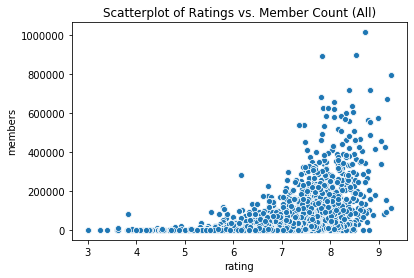

In [38]:
sns.scatterplot(x = 'rating', y = 'members', data = df).set_title('Scatterplot of Ratings vs. Member Count (All)')

In [39]:
stat, p = pearsonr(df['rating'], df['members'])

print('stat=%.3f, p=%.3f' % (stat, p))

if p > 0.05:
    print('Probably not statistically significant')
else:
    print('Probably statistically significant')

stat=0.503, p=0.000
Probably statistically significant


In these examples we can see a positive, skewed left linear relationship between anime ratings and the number of members who rated the anime. 

The way I would interpret this is that the more well-received an anime was, the more likely members were to rate it. Even so, the mean value of members is still visible, as this relationship isn't perfectly linear. This sort of finding will be useful to keep in mind as I build a recommendation system from this data.

# Content-based Recommender

This recommender will use cosine similarities between genre, rating, episode count, and the number of member ratings as features. Cosine similarity is determined by the angle theta between two entries. A smaller theta indicates more similar anime. I chose this method vs. TF-IDF because as all the information I provide is relevant to the recommendation, I would not want some words to be given less weight due to the nature of TF-IDF.

In [40]:
#selecting only the desired columns
anime = anime[['name', 'rating','episodes','genre', 'members']]

Since all of the text within each of these columns is relevant for recommendation, we will not need to clean the columns much more than just ensuring they are of the same data type for merger. All data points will be combined into one column so as to be compatiple with cosine similarity based recommendations.

In [41]:
#cleaning and preparing the columns for the recommender

#removing commas
anime['genre'] = anime['genre'].str.replace(',','')

#setting to strings
anime['rating'] = anime['rating'].astype(str)
anime['episodes'] = anime['episodes'].astype(str)
anime['members'] = anime['members'].astype(str)

#kreating a key column that includes all relevant information for recommendation
anime['keys'] = anime['genre'] + ' ' + anime['rating'] + ' ' + anime['episodes'] + ' ' + anime['members']
anime = anime[['name', 'keys']]
anime.head()

,name,keys
1,Fullmetal Alchemist: Brotherhood,Action Adventure Drama Fantasy Magic Military ...
2,Gintama°,Action Comedy Historical Parody Samurai Sci-Fi...
3,Steins;Gate,Sci-Fi Thriller 9.17 24 673572
4,Gintama&#039;,Action Comedy Historical Parody Samurai Sci-Fi...
5,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,Comedy Drama School Shounen Sports 9.15 10 93351


In [42]:
#Vectorizing the keys column
count = CountVectorizer()
count_matrix = count.fit_transform(anime['keys'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [43]:
#setting the dataframe index to be the anime name
anime = anime.set_index('name')

In [44]:
# creating a Series for the anime titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(anime.index)

#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def recommendations(title, cosine_sim = cosine_sim):
    
    # initializing the empty list of recommended movies
    recommended_anime = []
    
    # gettin the index of the anime that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar anime
    top_10 = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10:
        recommended_anime.append(list(anime.index)[i])
        
    return recommended_anime

In [45]:
#recommendations for the anime "Naruto"
recommendations('Naruto')

['Tenjou Tenge',
 'Dragon Ball Kai',
 'Dragon Ball Kai (2014)',
 'Medaka Box Abnormal',
 'Dragon Ball Z',
 'Medaka Box',
 'Rekka no Honoo',
 'Dragon Ball',
 'Taboo Tattoo',
 'Wolverine']

### Evaluation

Comparing these results to those on MyAnimeList.com, we can see that the model is producing fairly similar results! Though MyAnimeList uses a collaborative-filtering method paired with direct user recommendations, my model still manages to produce relevant results. For example, in the case of Naruto, Dragon Ball recommendations seem to dominate the Top 10. This is somewhat to be inspected as the creator of Naruto grew up watching Dragon Ball and was heavily inspired by it. Many similarities can be drawn between the two anime. 

For other shows such as Neon Genesis Evangelion, the model is able to even get the second highest entry exactly right with the myanimelist recommender. In fact, when looking at the top recommendation for Neon Genesis Evangelion I see that it recommends "The Big O". When looking up "The Big O" on myanimelist, I see that "Neon Genesis Evangelion" is also it's top recommendation! My model also provided both of them with some overlapping recommendations as well.


#### Where to improve

As I said before, the model works but it could definitely be better. By incorporating individual user data along with data on the anime itself, I would be able to get better results. Additionally, when looking at some of the top recommendations on the myanimelist website, I see that some of the highest ranked entries simply were never in my data set. For example, someone who liked Naruto would probably like its sequel, Naruto: Shippuuden, as well. But Shippuuden is not within the data set so it cannot be recommended. 

A big thing that the model barely captures is hype surrounding anime. As my earlier finding suggested, higher rated anime tends to also amass more individual ratings. Thus a more hyped and highly rated anime will be rated by more users. This I think was a useful inclusion, but with better data, I could have replaced this factor with direct user comments from the website itself (i.e. "If you liked Naruto, you'd probably like One Piece too"). By being able to capture hype, recommendations could have been made based on siilar hype.

I thought by including the episode count in the model, it could help match shows up with anime of similar length as well. Personally, I tend to watch anime that would fit into my long anime dataframe. I of course have been recommended Naruto and One Piece many times in person, but since they're both sporting episode counts in the hundreds, I pass. 

As I experimented with the model, I found that including all of these factors helped it perform the best it could.

## Conclusion

Overall this project taught me a few new things and helped me further identify the weaknesses certain data science approaches can bring. I look forward to revisiting this project to see how my thought process may have changed! For now, I will further test this model anecdotally. Neon Genesis Evangelion is perhaps my favorite anime. My model seems to think I'd probably like "The Big O", so I'll give that a watch and hopefully that will decide just how much I can rely on this.

In [46]:
#Recommendations for people that like "Neon Genesis Evangelion"
recommendations('Neon Genesis Evangelion')

['Aquarion Evol',
 'RahXephon',
 'The Big O',
 'Mugen no Ryvius',
 'M3: Sono Kuroki Hagane',
 'Gun x Sword',
 'Brain Powerd',
 'Reideen',
 'Trigun',
 'Kuromukuro']